<div class="alert" style="background-color:#BBA14F; color:white; padding:0px 10px; border-radius:5px;">
    <h1 style='margin:15px 15px; color:#000000; font-size:32px'><b>New Recurrent Network (best21_v16)</b></h1>
        <h2 style='margin:15px 15px; color:#000000; font-size:24px'>Human Activity Recognition Problem</h2>
</div>

The work is under the **"Master Thesis"** by **Chau Tran** with the supervision from **Prof. Roland Olsson**.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras.backend import eval

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, StandardScaler

import tensorboard
import keras
from keras.utils import tf_utils
import pandas as pd #pd.plotting.register_matplotlib_converters
import numpy as np
import sys, os, math, time, datetime, re

import matplotlib.pyplot as plt

print("tf: ", tf.__version__)
print("tb: ", tensorboard.__version__)
print(os.getcwd())

DTYPE = tf.float64
RANDOM_SEED = 42
ISMOORE_DATASETS = True
timestep = 40
tf.random.set_seed(np.random.seed(RANDOM_SEED))
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)
tf.config.set_visible_devices([], 'GPU')
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

tf.keras.backend.set_floatx('float64')

snapshot = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
path = '../../../../Datasets/6_har/0_WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_processed/WISDM_ar_v1.1_wt_overlap'
# Debugging with Tensorboard
logdir="logs/fit/rnn_v1_1/" + snapshot
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# tf.debugging.experimental.enable_dump_debug_info(logdir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

with open("../../params/params_har.txt") as f:
    hyperparams = dict([re.sub('['+' ,\n'+']','',x.replace(' .', '')).split('=') for x in f][1:-1])
hyperparams = dict([k, float(v)] for k, v in hyperparams.items())
hyperparams['testSize'] = 0.500
hyperparams['noUnits'] = 81
hyperparams['timestep'] = 40
print(hyperparams)

def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    plt.show()
    
def seperateValues(data, noInput, noOutput, isMoore=True):
    x_data, y_data = None, None
    for i in range(data.shape[0]):
        if isMoore:
            x_data_i = data[i].reshape(-1, noInput+noOutput)
            x_data_i, y_data_i = x_data_i[:, 0:noInput], x_data_i[-1, noInput:]
        else:
            x_data_i = data[i][:-1].reshape(-1, noInput)
            y_data_i = data[i][-1].reshape(-1, noOutput)
        x_data = x_data_i[np.newaxis,:,:] if x_data is None else np.append(x_data, x_data_i[np.newaxis,:,:], axis=0)
        y_data = y_data_i.reshape(1, -1) if y_data is None else np.append(y_data, y_data_i.reshape(1, -1), axis=0)
    return x_data, y_data

def fromBit_v0( b ) :
    return -0.9 if b == 0.0 else 0.9

def fromBit_v1( b ) :
    return 0 if b == 0.0 else 1

def isCorrect( target, actual ) :
    y1 = False if target < 0.0 else True
    y2 = False if actual < 0.0 else True
    return y1 == y2 

class CustomMetricError(tf.keras.metrics.MeanMetricWrapper):
    def __init__(self, name='custom_metric_error', dtype=None, threshold=0.5):
        super(CustomMetricError, self).__init__(
            customMetricfn_tensor, name, dtype=dtype, threshold=threshold)

    def customMetricfn_tensor(true, pred, threshold=0.5):
        true = tf.convert_to_tensor(true)
        pred = tf.convert_to_tensor(pred)
        threshold = tf.cast(threshold, pred.dtype)
        pred = tf.cast(pred >= threshold, pred.dtype)
        true = tf.cast(true >= threshold, true.dtype)
        return keras.backend.mean(tf.equal(true, pred), axis=-1)

def customMetricfn(y_true, y_pred):
    numCorrect = 0
    for i in range( y_true.shape[0] ) :
        for j in range( y_pred.shape[ 1 ] ) :
            if isCorrect( y_true[ i, j ], y_pred[ i, j ] ) :
                numCorrect += 1
    return (numCorrect/(y_pred.shape[1]*y_true.shape[0]))

def indexOfMax( xs ) :
    m, k = xs[ 0 ], 0
    for i in range( 0, xs.size ) :
        if xs[ i ] > m :
            m = xs[ i ]
            k = i
    return k

def customMetricfn_full(y_true, y_pred):
    numCorrect = 0
    for i in range(y_pred.shape[0]) :
        if indexOfMax(y_pred[i]) == indexOfMax(y_val[i]) :
            numCorrect += 1
    return numCorrect/y_pred.shape[0]
            
def srelu(x):
    return tf.keras.backend.clip(x, -1, 1)

def _generate_zero_filled_state_for_cell(cell, inputs, batch_size, dtype):
    if inputs is not None:
        batch_size = tf.shape(inputs)[0]
        dtype = inputs.dtype
    return _generate_zero_filled_state(batch_size, cell.state_size, dtype)

def _generate_zero_filled_state(batch_size_tensor, state_size, dtype):
    def create_zeros(unnested_state_size):
        flat_dims = tf.TensorShape(unnested_state_size).as_list()
        init_state_size = [batch_size_tensor] + flat_dims
        return tf.zeros(init_state_size, dtype=dtype)
    
    if batch_size_tensor is None or dtype is None:
        raise ValueError(
            'batch_size and dtype cannot be None while constructing initial state. '
            f'Received: batch_size={batch_size_tensor}, dtype={dtype}')

    return tf.nest.map_structure(create_zeros, state_size)  if tf.nest.is_nested(state_size) else create_zeros(state_size)

class RNN_plus_v1_16_cell(tf.keras.layers.LSTMCell):
    def __init__(self, units, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', dropout=0., recurrent_dropout=0., use_bias=True, **kwargs):
        if units < 0:
            raise ValueError(f'Received an invalid value for argument `units`, '
                                f'expected a positive integer, got {units}.')
        # By default use cached variable under v2 mode, see b/143699808.
        if tf.compat.v1.executing_eagerly_outside_functions():
            self._enable_caching_device = kwargs.pop('enable_caching_device', True)
        else:
            self._enable_caching_device = kwargs.pop('enable_caching_device', False)
        super(RNN_plus_v1_16_cell, self).__init__(units, **kwargs)
        self.units = units
        self.state_size = self.units
        self.output_size = self.units
        
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.recurrent_initializer = tf.keras.initializers.get(recurrent_initializer)
        self.aux_initializer = tf.keras.initializers.get('zeros')
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        
        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = [self.units, self.units, self.units, self.units, self.units]
        self.output_size = self.units
        self.use_bias = True
        self.cell_dtype = DTYPE
    
    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units * 2), name='w_input', initializer=self.kernel_initializer, regularizer=None, constraint=None, dtype=self.cell_dtype)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units * 4), name='w_otherpeeps', initializer=self.recurrent_initializer, regularizer=None, constraint=None, dtype=self.cell_dtype)
        self.aux_kernel  = self.add_weight(shape=(5, self.units), name='w_aux', initializer=self.recurrent_initializer, regularizer=None, constraint=None, dtype=self.cell_dtype)
        self.bias = self.add_weight( shape=(self.units,), name='b', initializer=self.bias_initializer, regularizer=None, constraint=None, dtype=self.cell_dtype) if self.use_bias else None
        self.built = True
        
    def call(self, inputs, states, training=None):
        state0, state1, state2, state3, prev_output = states[0], states[1], states[2], states[3], states[4]
        
        w_in_0, w_in_2 = tf.split(self.kernel, num_or_size_splits=2, axis=1)

        w_op0, w_op2, w_op3, w_op4 = tf.split(self.recurrent_kernel, num_or_size_splits=4, axis=1)
        w_op0 = tf.linalg.set_diag(w_op0, np.zeros((self.units,), dtype=np.float64))
        w_op2 = tf.linalg.set_diag(w_op2, np.zeros((self.units,), dtype=np.float64))
        w_op3 = tf.linalg.set_diag(w_op3, np.zeros((self.units,), dtype=np.float64))
        w_op4 = tf.linalg.set_diag(w_op4, np.zeros((self.units,), dtype=np.float64))
    
        w_aux = self.aux_kernel
        
        inputs_0 = tf.keras.backend.dot(inputs, w_in_0)
        # inputs_1 = tf.keras.backend.dot(inputs, w_in_1)
        inputs_2 = tf.keras.backend.dot(inputs, w_in_2)
        
        if self.bias is not None:
            inputs_0 = tf.keras.backend.bias_add(inputs_0, self.bias)
            # inputs_1 = tf.keras.backend.bias_add(inputs_1, self.bias)
            inputs_2 = tf.keras.backend.bias_add(inputs_2, self.bias)
            
        op0 = tf.keras.backend.dot(state0, w_op0)
        # op1 = tf.keras.backend.dot(state0, w_op1)
        op2 = tf.keras.backend.dot(state0, w_op2)
        op3 = tf.keras.backend.dot(state0, w_op3)
        op4 = tf.keras.backend.dot(state0, w_op4)
        
        z1 = tf.nn.tanh(tf.nn.tanh(tf.nn.tanh(op4*(w_aux[0]*op3 + inputs_0)))) # remove tanh(srelu(x))
        z2 = tf.nn.tanh(tf.nn.tanh(tf.nn.tanh(w_aux[1]*op2 + w_aux[2]*state3 + w_aux[3]))) # remove srelu(tanh(x))
        z3 = tf.nn.tanh(tf.nn.relu(inputs_2))
        z  = z1 - (z2 + z3)
        output = prev_output - (z - state1)*z

        return output, [z, state0, w_aux[4]*z + op0, state2, output]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return list(_generate_zero_filled_state_for_cell(self, inputs, batch_size, dtype))

class LearningRateLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Learning Rate: ", self.model.optimizer.learning_rate.lr)
    
    def on_epoch_end(self, epoch, logs=None):
        tf.summary.scalar('learning rate', self.model.optimizer.learning_rate.lr, step=epoch)

class customLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, batchSize, initialLearningRate, learningRateDecay, 
                 decayDurationFactor, numTrainingSteps, name=None):
        self.name                 = name
        self.cell_dtype           = DTYPE
        self.batchSize            = tf.constant(batchSize, dtype=self.cell_dtype, name="bz")
        self.initialLearningRate  = tf.constant(initialLearningRate, dtype=self.cell_dtype, name="lr0") 
        self.learningRateDecay    = tf.constant(learningRateDecay, dtype=self.cell_dtype, name="alpha")
        self.decayDurationFactor  = tf.constant(decayDurationFactor, dtype=self.cell_dtype, name="beta")
        self.numTrainingSteps     = tf.constant(numTrainingSteps, dtype=self.cell_dtype, name="ortho")
        self.T                    = tf.constant(self.decayDurationFactor*(self.numTrainingSteps/self.batchSize), 
                                                dtype=self.cell_dtype, name="T")
        self.lr                   = tf.Variable(self.initialLearningRate, dtype=self.cell_dtype, name="lr")
    
    def __call__(self, step):
        self.t = tf.cast(step, self.cell_dtype)
        self.lr = tf.cond(self.t > self.T, 
           lambda: self.learningRateDecay * self.initialLearningRate,
           lambda: self.initialLearningRate -(1.0-self.learningRateDecay)*self.initialLearningRate*self.t/self.T
          )
        return self.lr
    
    def get_config(self):
        return {
            "name":           self.name,
            "cell_dtype":     self.cell_dtype,
            "batchSize":      self.batchSize,
            "initial_lr":     self.initialLearningRate,
            "decay_rate":     self.learningRateDecay,
            "decay_duration": self.decayDurationFactor,
            "training_step":  self.numTrainingSteps,
            "curr_lr":        self.lr
        }
    
def rnn_plus_model(noInput, noOutput, timestep):
    """Builds a recurrent model."""
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.RNN(cell=RNN_plus_v1_16_cell(units=hyperparams['noUnits']), input_shape=[timestep, noInput], unroll=False, name='RNNp_layer', dtype=DTYPE))
    model.add(tf.keras.layers.Dense(noInput+noOutput, activation='tanh', name='MLP_layer'))
    model.add(tf.keras.layers.Dense(noOutput, name='Output_layer'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=customLRSchedule(hyperparams['batchSize'], hyperparams['initialLearningRate'], hyperparams['learningRateDecay'], hyperparams['decayDurationFactor'], hyperparams['numTrainingSteps']), \
                                        beta_1=hyperparams['beta1'], beta_2=hyperparams['beta2'], epsilon=hyperparams['epsilon'], amsgrad=False, name="tunedAdam")
    model.compile(optimizer=optimizer, loss = 'mse', run_eagerly=False)
    print(tf.keras.backend.floatx())
    print(model.summary())
    return model

tf:  2.6.0
tb:  2.6.0
/home/ifeai/ChauTran/git/0_HIOF_Studying/0_MasterProject/tf_implementation/notebooks/rnnplus_for_har
{'batchSize': 4.0, 'numTrainingSteps': 320000.0, 'beta1': 0.974833, 'beta2': 0.99689, 'epsilon': 0.00388, 'decayDurationFactor': 0.979079, 'initialLearningRate': 0.002798, 'learningRateDecay': 0.001025, 'glorotScaleFactor': 0.1, 'orthogonalScaleFactor': 0.1, 'testSize': 0.5, 'noUnits': 81, 'timestep': 40}


{'batchSize': 4.0, 'numTrainingSteps': 320000.0, 'beta1': 0.974833, 'beta2': 0.99689, 'epsilon': 0.00388, 'decayDurationFactor': 0.979079, 'initialLearningRate': 0.002798, 'learningRateDecay': 0.001025, 'glorotScaleFactor': 0.1, 'orthogonalScaleFactor': 0.1, 'testSize': 0.5, 'noUnits': 81, 'timestep': 40}


(13769, 40, 3)

float64
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0472 - val_loss: 0.0357
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0305 - val_loss: 0.0287
Epoch 3/23


array(['Upstair', 'Downstair', 'Sitting', ..., 'Sitting', 'Walking',
       'Jogging'], dtype='<U21')

array(['Upstair', 'Downstair', 'Sitting', ..., 'Sitting', 'Walking',
       'Jogging'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.46 %
Jogging     : 99.13 %
Sitting     : 98.71 %
Standing    : 99.68 %
Upstair     : 91.59 %
Downstair   : 87.4 %


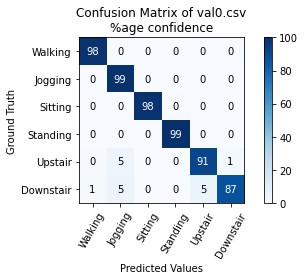

(13769, 40, 3)

float64
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 58s 17ms/step - loss: 0.0499 - val_loss: 0.0356
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 16ms/step - loss: 0.0288 - val_loss: 0.0211
Epoch 3/2

array(['Jogging', 'Downstair', 'Jogging', ..., 'Jogging', 'Downstair',
       'Downstair'], dtype='<U21')

array(['Jogging', 'Downstair', 'Jogging', ..., 'Jogging', 'Downstair',
       'Downstair'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 99.02 %
Jogging     : 98.74 %
Sitting     : 98.52 %
Standing    : 99.04 %
Upstair     : 91.61 %
Downstair   : 90.21 %


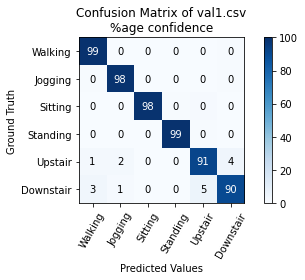

(13769, 40, 3)

float64
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0509 - val_loss: 0.0337
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0282 - val_loss: 0.0280
Epoch 3/2

array(['Downstair', 'Jogging', 'Upstair', ..., 'Downstair', 'Walking',
       'Downstair'], dtype='<U21')

array(['Downstair', 'Jogging', 'Upstair', ..., 'Downstair', 'Walking',
       'Downstair'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.73 %
Jogging     : 98.81 %
Sitting     : 98.79 %
Standing    : 99.34 %
Upstair     : 92.13 %
Downstair   : 90.13 %


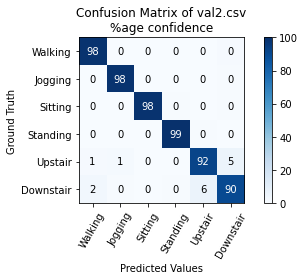

(13769, 40, 3)

float64
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0463 - val_loss: 0.0305
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 3/2

array(['Jogging', 'Standing', 'Downstair', ..., 'Downstair', 'Downstair',
       'Upstair'], dtype='<U21')

array(['Jogging', 'Standing', 'Downstair', ..., 'Downstair', 'Downstair',
       'Upstair'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.81 %
Jogging     : 98.58 %
Sitting     : 98.93 %
Standing    : 99.51 %
Upstair     : 90.62 %
Downstair   : 92.22 %


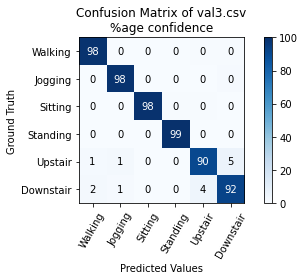

(13769, 40, 3)

float64
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0486 - val_loss: 0.0319
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0286 - val_loss: 0.0323
Epoch 3/2

array(['Walking', 'Walking', 'Upstair', ..., 'Jogging', 'Downstair',
       'Jogging'], dtype='<U21')

array(['Walking', 'Walking', 'Upstair', ..., 'Jogging', 'Downstair',
       'Jogging'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.94 %
Jogging     : 98.92 %
Sitting     : 98.59 %
Standing    : 98.4 %
Upstair     : 91.12 %
Downstair   : 87.24 %


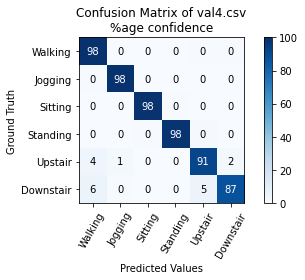

(13769, 40, 3)

float64
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0460 - val_loss: 0.0297
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0263 - val_loss: 0.0219
Epoch 3/2

array(['Walking', 'Sitting', 'Jogging', ..., 'Downstair', 'Jogging',
       'Walking'], dtype='<U21')

array(['Walking', 'Sitting', 'Jogging', ..., 'Downstair', 'Jogging',
       'Walking'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.64 %
Jogging     : 98.81 %
Sitting     : 98.25 %
Standing    : 98.68 %
Upstair     : 93.3 %
Downstair   : 87.77 %


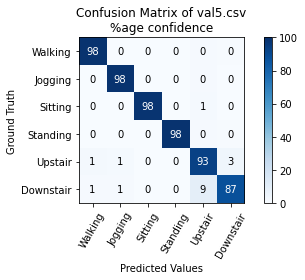

(13769, 40, 3)

float64
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0479 - val_loss: 0.0323
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0280 - val_loss: 0.0244
Epoch 3/2

array(['Downstair', 'Downstair', 'Jogging', ..., 'Jogging', 'Jogging',
       'Jogging'], dtype='<U21')

array(['Downstair', 'Downstair', 'Jogging', ..., 'Jogging', 'Upstair',
       'Jogging'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.65 %
Jogging     : 98.97 %
Sitting     : 99.16 %
Standing    : 99.36 %
Upstair     : 91.39 %
Downstair   : 90.97 %


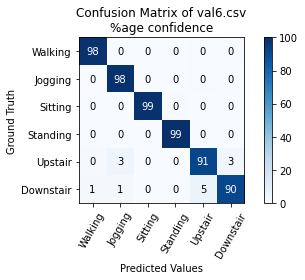

(13769, 40, 3)

float64
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNNp_layer (RNN)             (None, 81)                27216     
_________________________________________________________________
MLP_layer (Dense)            (None, 9)                 738       
_________________________________________________________________
Output_layer (Dense)         (None, 6)                 60        
Total params: 28,014
Trainable params: 28,014
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
Learning Rate:  <tf.Variable 'lr:0' shape=() dtype=float64, numpy=0.002798>
3443/3443 [==============================] - 59s 17ms/step - loss: 0.0521 - val_loss: 0.0323
Epoch 2/23
Learning Rate:  tf.Tensor(0.0026751340253423116, shape=(), dtype=float64)
3443/3443 [==============================] - 57s 17ms/step - loss: 0.0263 - val_loss: 0.0215
Epoch 3/2

array(['Jogging', 'Downstair', 'Upstair', ..., 'Jogging', 'Jogging',
       'Upstair'], dtype='<U21')

array(['Jogging', 'Downstair', 'Walking', ..., 'Jogging', 'Jogging',
       'Upstair'], dtype='<U21')

Accuracy for each class is given below.
Walking     : 98.73 %
Jogging     : 98.23 %
Sitting     : 98.17 %
Standing    : 99.07 %
Upstair     : 92.04 %
Downstair   : 89.8 %


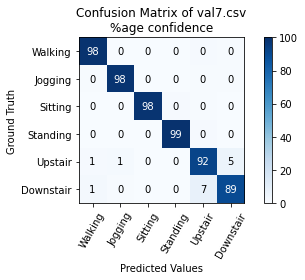

In [2]:
if __name__ == '__main__':
    ISMOORE_DATASETS = True
    noIn, noOut = 3, 6
    path = './../../../Datasets/6_har/0_WISDM/WISDM_ar_v1.1/wisdm_script_and_data/wisdm_script_and_data/WISDM/testdata'
    fileslist = [f for f in sorted(os.listdir(path)) if os.path.isfile(os.path.join(path, f))]
    logdir = f"./logs/scalars/wisdm"
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    print(hyperparams)
    result_history = {}
    for file_no in range(8):
        trainFile = f'train{file_no}.csv'
        valFile   = f'val{file_no}.csv'
        df_train  = np.array(pd.read_csv(os.path.join(path, trainFile), skiprows=1))
        df_val    = np.array(pd.read_csv(os.path.join(path, valFile), skiprows=1))

        scaler    = StandardScaler()
        x_train, y_train = seperateValues(df_train, noIn, noOut, isMoore=ISMOORE_DATASETS)
        x_val,   y_val   = seperateValues(df_val,   noIn, noOut, isMoore=ISMOORE_DATASETS) 
        display(x_train.shape)
        x_train   = (scaler.fit_transform(x_train.reshape(x_train.shape[0], -1))).reshape(x_train.shape[0], hyperparams['timestep'], noIn)
        x_val     = (scaler.fit_transform(x_val.reshape(x_val.shape[0], -1))).reshape(x_val.shape[0], hyperparams['timestep'], noIn)
        
        model = rnn_plus_model(noIn, noOut, timestep=hyperparams['timestep'])
        model_history = model.fit(
                            x_train, y_train,
                            batch_size=int(hyperparams['batchSize']),
                            verbose=1, # Suppress chatty output; use Tensorboard instead
                            epochs=int(hyperparams['numTrainingSteps']/(x_train.shape[0])),
                            validation_data=(x_val, y_val),
                            shuffle=True,
                            use_multiprocessing=False,
                            callbacks=[tensorboard_callback, LearningRateLoggingCallback()],
                        )
        y_pred = model.predict(x_val, verbose=0, batch_size=int(hyperparams['batchSize']))
        val_performance = model.evaluate(x_val, y_val, batch_size=int(hyperparams['batchSize']), verbose=0)
        print(f"{valFile} val_performance = {val_performance}")
        print(f"{valFile} val accuracy = {round(customMetricfn_full(y_val, y_pred), 5)}")
        result_history[f"{valFile}"] = {}
        result_history[f"{valFile}"]['y_val'] = y_val
        result_history[f"{valFile}"]['y_pred'] = y_pred
        result_history[f"{valFile}"]['val_performance'] = val_performance
        result_history[f"{valFile}"]['val_accuracy'] = round(customMetricfn_full(y_val, y_pred), 5)
        print(f"{valFile} val_performance = {val_performance}")
        print(f"{valFile} val accuracy = {round(customMetricfn_full(y_val, y_pred), 5)}")
        predictedClass = np.zeros((y_pred.shape[0]), dtype = int)
        groundTruthClass = np.zeros((y_val.shape[0]), dtype = int)
        for instance in range (y_val.shape[0]):
            predictedClass[instance] = np.argmax(y_pred[instance,:])
            groundTruthClass[instance] = np.argmax(y_val[instance,:])
        predictedClass = np.where(predictedClass.astype(str) == '0', 'Walking', predictedClass)
        predictedClass = np.where(predictedClass.astype(str) == '1', 'Jogging', predictedClass)
        predictedClass = np.where(predictedClass.astype(str) == '2', 'Sitting', predictedClass)
        predictedClass = np.where(predictedClass.astype(str) == '3', 'Standing', predictedClass)
        predictedClass = np.where(predictedClass.astype(str) == '4', 'Upstair', predictedClass)
        predictedClass = np.where(predictedClass.astype(str) == '5', 'Downstair', predictedClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '0', 'Walking', groundTruthClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '1', 'Jogging', groundTruthClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '2', 'Sitting', groundTruthClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '3', 'Standing', groundTruthClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '4', 'Upstair', groundTruthClass)
        groundTruthClass = np.where(groundTruthClass.astype(str) == '5', 'Downstair', groundTruthClass)
        display(predictedClass)
        display(groundTruthClass)
        result_history[f"{valFile}"]['confusion_matrix'] = metrics.confusion_matrix(groundTruthClass, predictedClass)
        tags = np.array(['Walking', 'Jogging', 'Sitting', 'Standing', 'Upstair', 'Downstair'])
        # obtaining a confusion matrix  
        cm = metrics.confusion_matrix(groundTruthClass, predictedClass)
        # plotting the confusion matrix
        plot_cm(cm, tags, f'Confusion Matrix of {valFile}')